# Audio MNIST again - let's check out other transformations offered by librosa!

In [1]:
import librosa

In [2]:
import jax
import jax.numpy as jnp
import flax
import flax.linen
import netket as nk
import os
import matplotlib.pyplot as plt

from jax.experimental import stax

import numpy as np

/Users/theresatratzmuller/Documents/Code.nosync/ws21_22/ml/ml_env/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [3]:
#
# EXTRACT STFT
#
def extract_stft(file_path, utterance_length): 
    # Get raw .wav data and sampling rate from librosa's load function
    raw_w, sampling_rate = librosa.load(file_path, mono=True)

    N = 256
    
    H = 62
    
    # run stft 
    stft_features = librosa.stft(raw_w, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
    
    if stft_features.shape[1] > utterance_length:
        stft_features = stft_features[:, 0:utterance_length]
    else:
        stft_features = np.pad(stft_features, ((0, 0), (0, utterance_length - stft_features.shape[1])),
                               mode='constant', constant_values=0)
    
    return stft_features

In [4]:
#
# GET TRAINING DATA (batching done later)
#
def get_stft_train_data(file_path, utterance_length):
    print("hello")
    files = os.listdir(file_path)
    fts = []
    labels = []

    for fname in files:
        # print("Total %d files in directory" % len(files))

        # Make sure file is a .wav file
        if not fname.endswith(".wav"):
            continue

        # Get MFCC Features for the file
        stft_features = extract_stft(file_path + fname, utterance_length)

        # One-hot encode label for 10 digits 0-9
        # label = np.eye(10)[int(fname[0])]

        # Append to label batch
        labels.append(int(fname[0]))

        # Append mfcc features to ft_batch
        fts.append(stft_features)
    
    return fts, labels

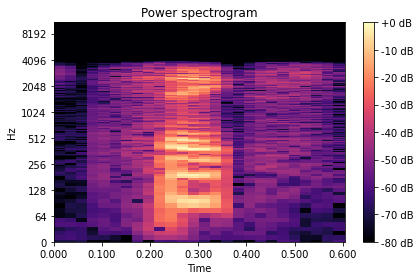

In [5]:
# Visual demonstration for example file
y, sr = librosa.load('audio_data/recordings/train/6_lucas_17.wav')

D = np.abs(librosa.stft(y))

import matplotlib.pyplot as plt

import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max) ,y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

## Let's check out our stft data!

In [6]:
utterance_length = 35

In [7]:
fts, labels = get_stft_train_data('audio_data/recordings/train/', utterance_length)

hello


In [8]:
type(fts)

list

In [9]:
type(fts[0])

numpy.ndarray

In [10]:
fts[700].shape

(129, 35)

The features are currently a list of ndarrays where each has shape 129, 121. Note: if we use jnp instead of np in the above functions, we get JAX' DeviceArrays instead.

In [11]:
fts[0]

array([[-5.9746134e-01+0.0000000e+00j, -5.6824845e-01+0.0000000e+00j,
        -8.7899452e-01+0.0000000e+00j, ...,
        -1.2379650e+00+0.0000000e+00j, -7.3767132e-01+0.0000000e+00j,
        -8.0603790e-01+0.0000000e+00j],
       [ 4.3833560e-01-4.9414119e-01j,  2.5710037e-01+5.5397564e-01j,
         2.1151027e-01-8.6355937e-01j, ...,
         1.5453712e+00-5.1962423e-01j, -9.3220845e-03+1.1204453e+00j,
         6.2984906e-02-1.2177564e+00j],
       [ 2.4752937e-01+6.0169786e-01j, -3.6967495e-01-1.3430399e+00j,
         1.8289559e-01+1.4645554e+00j, ...,
        -5.6190461e-01-1.4778465e-01j, -1.4558232e-01-1.7886128e+00j,
         9.4790302e-02+1.9570192e+00j],
       ...,
       [ 3.3277238e-04-7.7198902e-06j, -1.7241458e-04-1.2712551e-05j,
         3.9209172e-07-8.0385618e-08j, ...,
        -9.9917520e-07+5.1448143e-07j, -8.9935721e-09-1.8333493e-07j,
         8.2057198e-07+1.6660744e-07j],
       [-3.3297169e-04+3.9849274e-06j, -6.5150025e-06+1.7251111e-04j,
         3.9589304e-07

In [12]:
type(labels)

list

In [13]:
type(labels[0])

int

In [14]:
labels[0]

5

### The data should be in the exact same format as they data in our original notebook, because I want to reuse the code hehe!

I will now try to format the data so as to exactly match the structure of the data used in our original notebook so I can use the exact same code lol

Convert from list to array:

In [15]:
type(fts)

list

In [16]:
fts_array = np.array(fts)

In [17]:
labels_array = np.array(labels)

In [18]:
train_data = {'features': fts_array, 'labels': labels_array}

In [19]:
train_data

{'features': array([[[-5.97461343e-01+0.00000000e+00j,
          -5.68248451e-01+0.00000000e+00j,
          -8.78994524e-01+0.00000000e+00j, ...,
          -1.23796499e+00+0.00000000e+00j,
          -7.37671316e-01+0.00000000e+00j,
          -8.06037903e-01+0.00000000e+00j],
         [ 4.38335598e-01-4.94141191e-01j,
           2.57100374e-01+5.53975642e-01j,
           2.11510271e-01-8.63559365e-01j, ...,
           1.54537117e+00-5.19624233e-01j,
          -9.32208449e-03+1.12044525e+00j,
           6.29849061e-02-1.21775639e+00j],
         [ 2.47529373e-01+6.01697862e-01j,
          -3.69674951e-01-1.34303987e+00j,
           1.82895586e-01+1.46455538e+00j, ...,
          -5.61904609e-01-1.47784650e-01j,
          -1.45582318e-01-1.78861284e+00j,
           9.47903022e-02+1.95701921e+00j],
         ...,
         [ 3.32772383e-04-7.71989016e-06j,
          -1.72414584e-04-1.27125513e-05j,
           3.92091721e-07-8.03856182e-08j, ...,
          -9.99175199e-07+5.14481428e-07j,
     

### Gotta do the exact same thing for test data set ... 

In [20]:
fts_test, labels_test = get_stft_train_data('audio_data/recordings/test/', utterance_length)

hello


In [21]:
fts_test_array = np.array(fts_test)

In [22]:
fts_test_array[200].shape

(129, 35)

In [23]:
labels_test_array = np.array(labels_test)

In [24]:
test_data = {'features': fts_test_array, 'labels': labels_test_array}

### Let's go and setup our toolbox!

In [28]:
def complex_relu(z):
    return jnp.where(z.real > 0, z, 0)

In [29]:
import cvnn

In [30]:
# Same model as above but complex
class Model(nk.nn.Module):
  n_classes : int = 10
  @nk.nn.compact
  # Provide a constructor to register a new parameter 
  # and return its initial value
  def __call__(self, x):

    x = nk.nn.Conv(features=32, kernel_size=(3, 3), dtype=complex)(x)

    print("First conv layer!")
    
    print(x.shape)
    
    x = complex_relu(x) # not too great results
    
    #x = nk.nn.activation.log_tanh(x) # shit results
    
    #x = cvnn.activations.zrelu(x).numpy() # fails because cvnn uses tensorflow
    
    print("First complex relu comp.")
    
    print(x.shape)

    x = flax.linen.avg_pool(x, window_shape=(1, 3), strides=(1, 3)) 
    
    print("First avg pool")
    
    print(x.shape)
    
    x = nk.nn.Conv(features=64, kernel_size=(3, 3), dtype=complex)(x)

    print("2nd conv layer!")
    
    print(x.shape)
    
    x = complex_relu(x) # not too great results
    
    #x = nk.nn.activation.log_tanh(x) # shit results
    
    #x = cvnn.activations.zrelu(x).numpy() # fails because cvnn uses tensorflow

    print("2nd complex relu comp.")
    
    print(x.shape)
    
    x = flax.linen.avg_pool(x, window_shape=(1, 3), strides=(1, 3))
    
    print("2nd avg pool")

    print(x.shape)
    
    x = x.reshape((x.shape[0], -1)) # Flatten
    
    x = nk.nn.Dense(features=256, dtype=complex)(x)

    x = complex_relu(x) # not too great results
    
    #x = nk.nn.activation.log_tanh(x) # shit results
    
    #x = cvnn.activations.zrelu(x).numpy() # fails because cvnn uses tensorflow

    x = nk.nn.Dense(features=10, dtype=complex)(x)    # There are 10 classes in MNIST

    x = jnp.abs(x) #<= I guess this isn't required anymore?

    # In the Jax tutorial, log_softmax is used - should we use it too?
    # => let's try
    x = nk.nn.log_softmax(x)

    return x

In [31]:
test_data['features'].shape

(300, 129, 35)

In [32]:
seed = 123
seed_dropout = 0

model = Model(n_classes=10)

sample_input = jnp.ones([1, 129, 35])

# Dropout was added (compared to Deep Learning Tut - why?)

key = {'params': jax.random.PRNGKey(seed), 'dropout': jax.random.PRNGKey(seed_dropout)}
pars = model.init(key, sample_input)

First conv layer!
(1, 129, 32)
First complex relu comp.
(1, 129, 32)
First avg pool
(1, 43, 32)
2nd conv layer!
(1, 43, 64)
2nd complex relu comp.
(1, 43, 64)
2nd avg pool
(1, 14, 64)


Note: jnp.ones is now an array of size 3, whereas it was an array of size 4 in our original MNIST notebook. Thus, the aggregation kernel of size (2,2) didn't work. I am hence currently using a kernel of size (1,3), no idea if that is reasonable at all, but hey! Good enough for an MVP I'd say

Should probably use a different aggregation, i.e. one described [here](https://arxiv.org/pdf/1602.09046.pdf)

In [33]:
# The loss function that we will use
def cross_entropy(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [34]:
dropout_rng, init_dropout = jax.random.split(jax.random.PRNGKey(1))

In [35]:
def loss_fn(params, dropout_rng, features, labels):
    """
    Loss function minimised during training of the model.
    """
    # compute the output of the model, which gives the 
    # log-probability distribution over the possible classes (0...9)
    logits = model.apply(params, features, rngs={'dropout' : dropout_rng})
    # feed it to the cross_entropy
    return cross_entropy(logits=logits, labels=labels)

def compute_metrics(*, logits, labels):
    """
    Compute metrics of the model during training.
    
    Returns the loss and the accuracy.
    """
    loss = cross_entropy(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics

In [36]:
import optax
from flax.training import train_state  # Useful dataclass to keep train state

def create_train_state(rng, optimiser, dropout_rng):
    """Creates initial `TrainState`, holding the current parameters, state of the
    optimiser and other metadata.
    """
    # Construct the model parameters
    params = model.init({'params' : rng, 'dropout' : dropout_rng}, jnp.ones([1, 129, 35]))
        
    # Package all those informations in the model state
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=optimiser)

In [37]:
@jax.jit
def eval_metrics(params, batch, dropout_rng):
    """
    This function evaluates the metrics without training the model.
    
    Used to check the performance of the network on training and test datasets.
    """
    logits = model.apply(params, batch['features'], rngs={'dropout' : dropout_rng})
    return compute_metrics(logits=logits, labels=batch['labels'])

In [38]:
# Partial is handy as it can be used to 'fix' some arguments to a function.
# so partial(f, x)(y) == f(x,y)
from functools import partial

@jax.jit
def train_step(state, batch, dropout_rng):
    """
    Train for a single step.
    
    The input images `batch` should not be too large, otherwise we will run
    out of memory. Therefore the input should be 'batched', meaning should be
    separated into small blocks of ~hundreds (instead of tens of thousands)
    iamges.
    """
    # Fix some arguments to the loss function (so that the only 'free' parameter is
    # the parameters of the network.
    _loss_fn = partial(loss_fn, dropout_rng = dropout_rng, features=batch['features'], labels=batch['labels'])
    # construct the function returning the loss value and gradient.
    val_grad_fn = jax.value_and_grad(_loss_fn)
    # compute loss and gradient
    loss, grads = val_grad_fn(state.params)

    # NEW: MANUALLY CONJUGATE THE GRADIENTS!!!! THANKS DIAN <3
    grads = jax.tree_map(lambda x: x.conj(), grads) # <- Add this!

    # update the state parameters with the new gradients
    # objects are immutable so the output of this function is a different
    # object than the starting one.
    state = state.apply_gradients(grads=grads)
    
    # Evaluate the network again to get the log-probability distribution
    # over the batch images
    metrics = eval_metrics(state.params, batch, dropout_rng)
    
    return state, metrics

In [39]:
def train_epoch(state, train_ds, batch_size, epoch, rng, dropout_rng, *, max_steps=None):
    """Train for a single `epoch`.
    
    And epoch is composed of several steps, where every step is taken by updating
    the network parameters with a small mini-batch.
    """
    
    # total number of training images
    train_ds_size = len(train_data['features'])
    
    # Compute how many steps are present in this epoch.
    # In one epoch we want to go through the whole dataset.
    steps_per_epoch = train_ds_size // batch_size

    # Truncate the number of steps (used to speed up training)
    # Sometimes we might want not to go through the whole dataset
    # in an epoch.
    if max_steps is not None:
        steps_per_epoch = min(steps_per_epoch, max_steps)

    # generate a random permutation of the indices to shuffle the training
    # dataset, and reshape it to a set of batches.
    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))
    
    # execute the training step for every mini-batch
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch, dropout_rng)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
            for k in batch_metrics_np[0]}

    return state, epoch_metrics_np


def evaluate_model(params, test_ds, dropout_rng):
    """
    evaluate the performance of the model on the test dataset
    """
    metrics = eval_metrics(params, test_ds, dropout_rng)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

In [40]:
# Definition of optimiser HyperParameters

learning_rate = 0.001

"""
Standard SGD step size
"""
momentum = 0.9
"""
Amount of memntum. The maximum effective learning rate will be
$ learning_rate * momentum/(1-momentum)$
"""

# Construct the optimiser
# we use optimisers from the optax package which is a very comprehensive
# optimiser library
optimiser = optax.sgd(learning_rate, momentum)

In [41]:
num_epochs = 50
"""
"""

batch_size = 32
"""
"""

max_steps = 500
"""
Cutoff to the number of steps (minibatches) in an epoch
""";

In [42]:
# Split the rng to get two keys, one to 'shuffle' the dataset at every iteration,
# and one to initialise the network
rng, init_rng = jax.random.split(jax.random.PRNGKey(0))

In [43]:
# Import the TQDM progress bar module using automatic notebook detection
# Otherwise it would not work..
from tqdm.auto import tqdm

state = create_train_state(init_rng, optimiser, init_dropout)

metrics = {"test_loss" : [], "test_accuracy": [], "train_loss":[], "train_accuracy":[]}

with tqdm(range(1, num_epochs + 1)) as pbar:
    for epoch in pbar:
        # Use a separate PRNG key to permute image data during shuffling
        rng, input_rng = jax.random.split(rng)
        dropout_rng, _ = jax.random.split(dropout_rng)
        # Run an optimization step over a training batch
        state, train_metrics = train_epoch(state, train_data, batch_size, epoch, input_rng, dropout_rng)
        
        # Evaluate on the test set after each training epoch
        test_loss, test_accuracy = evaluate_model(state.params, test_data, dropout_rng)
        pbar.write('train epoch: %d, loss: %.4f, accuracy: %.2f' % (epoch, train_metrics['loss'], train_metrics['accuracy'] * 100))
        pbar.write(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (epoch, test_loss, test_accuracy * 100))

        # save data
        metrics["train_loss"].append(train_metrics["loss"])
        metrics["train_accuracy"].append(train_metrics["accuracy"])
        metrics["test_loss"].append(test_loss)
        metrics["test_accuracy"].append(test_accuracy)

First conv layer!
(1, 129, 32)
First complex relu comp.
(1, 129, 32)
First avg pool
(1, 43, 32)
2nd conv layer!
(1, 43, 64)
2nd complex relu comp.
(1, 43, 64)
2nd avg pool
(1, 14, 64)


  0%|          | 0/50 [00:00<?, ?it/s]

First conv layer!
(32, 129, 32)
First complex relu comp.
(32, 129, 32)
First avg pool
(32, 43, 32)
2nd conv layer!
(32, 43, 64)
2nd complex relu comp.
(32, 43, 64)
2nd avg pool
(32, 14, 64)
First conv layer!
(32, 129, 32)
First complex relu comp.
(32, 129, 32)
First avg pool
(32, 43, 32)
2nd conv layer!
(32, 43, 64)
2nd complex relu comp.
(32, 43, 64)
2nd avg pool
(32, 14, 64)
First conv layer!
(300, 129, 32)
First complex relu comp.
(300, 129, 32)
First avg pool
(300, 43, 32)
2nd conv layer!
(300, 43, 64)
2nd complex relu comp.
(300, 43, 64)
2nd avg pool
(300, 14, 64)
train epoch: 1, loss: 2.3026, accuracy: 10.53
 test epoch: 1, loss: 2.30, accuracy: 11.33
train epoch: 2, loss: 2.2975, accuracy: 12.69
 test epoch: 2, loss: 2.29, accuracy: 14.67
train epoch: 3, loss: 2.2934, accuracy: 13.13
 test epoch: 3, loss: 2.29, accuracy: 16.00
train epoch: 4, loss: 2.2874, accuracy: 15.48
 test epoch: 4, loss: 2.28, accuracy: 16.33
train epoch: 5, loss: 2.2847, accuracy: 16.48
 test epoch: 5, lo

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(12,3))

axs[0].plot(metrics["train_loss"], label="train")
axs[0].plot(metrics["test_loss"], label="test")
axs[0].legend()
axs[0].set_xlabel("Epoch #")
axs[0].set_ylabel("Loss")


axs[1].plot(metrics["train_accuracy"], label="train")
axs[1].plot(metrics["test_accuracy"], label="test")
axs[1].legend()
axs[1].set_xlabel("Epoch #")
axs[1].set_ylabel("Accuracy")